In [1]:
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.evaluation import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

hydra.initialize()

In [2]:
base_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/'

In [40]:
img_nrs = [150,151,47]

means = [load_tiff_image(base_dir + f'/aligned_images{nr}.tif').mean(-1).mean(-1) for nr in img_nrs]

In [32]:
import tifffile
def rescale_MOp_tiffstack_by_mean(base_dir, inp_file, out_file, out_mean):
    
    vol_stack = cpu(load_tiff_image(base_dir + inp_file))
    ch_means = vol_stack.mean(-1).mean(-1).mean(-1)[:22]
    
    scaled_vol = vol_stack[:22] / ch_means[:,None,None,None] * ch_means.mean()#out_mean
    
    tifffile.imsave(base_dir + out_file, scaled_vol)

In [60]:
from decode_fish.funcs.dataset import GaussianSmoothing
from scipy import stats
import tifffile
def rescale_MOp_tiffstack_by_theta(base_dir, inp_file, out_file):

    vol_stack = cpu(load_tiff_image(base_dir + inp_file))
    img_5d = torch.tensor(vol_stack[:22][None]).permute([2,1,0,3,4])
    print(img_5d.shape)
    vol_mean = img_5d.mean().item()
    
    thetas = np.zeros(img_5d.shape[:2])
    smoother = GaussianSmoothing(smoothing_filter_size=9)

    for i in tqdm(range(len(img_5d))):
        mask = 1 - get_roi_mask(img_5d[i], pool_size=(10,10,10), percentile=50)
        for c in range(img_5d.shape[1]):

            bg_est = smoother(img_5d[i][c,:,:,:].to('cuda'))
            theta = estimate_noise_scale(img_5d[i][c][mask.nonzero()], bg_est[mask.nonzero()], percentile=98, plot=False)

            thetas[i,c] = theta

    ch_facs = 1/thetas.mean(0)
    
    scaled_vol = vol_stack[:22] * ch_facs[:,None,None,None]
    scaled_vol *= vol_mean/scaled_vol.mean()
    
    tifffile.imsave(base_dir + out_file, scaled_vol)

In [39]:
for nr in [150,151,47]:
    rescale_MOp_tiffstack_by_theta(base_dir, f'/aligned_images{nr}.tif', f'/aligned_scaled4_images{nr}.tif')

torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:26<00:00, 12.41s/it]


torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:48<00:00,  6.93s/it]


torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.79s/it]


In [26]:
# from decode_fish.funcs.exp_specific import read_MOp_tiff
import tifffile
def rescale_MOp_tiffstack_by_theta_col(base_dir, inp_file, out_file):

    img_5d = read_MOp_tiff(base_dir + inp_file, z_to_batch=True)
    
    ch_cols = np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0])
    ind0 = ch_cols==0
    ind1 = ch_cols==1
    
    vol_mean1 = img_5d[:,ind0].mean()
    vol_mean2 = img_5d[:,ind1].mean()
    
    print(img_5d.shape)
    
    thetas = np.zeros(img_5d.shape[:2])
    smoother = GaussianSmoothing(smoothing_filter_size=9)

    for i in tqdm(range(len(img_5d))):
        mask = 1 - get_roi_mask(img_5d[i], pool_size=(10,10,10), percentile=50)
        for c in range(img_5d.shape[1]):

            bg_est = smoother(img_5d[i][c,:,:,:].to('cuda'))
            theta = estimate_noise_scale(img_5d[i][c][mask.nonzero()], bg_est[mask.nonzero()], percentile=98, plot=False)

            thetas[i,c] = theta

    ch_facs = 1/thetas.mean(0)
    print(ch_facs)
    
    scaled_vol = img_5d * ch_facs[None:,None,None,None]
    scaled_vol[:,ind0] *= vol_mean1/scaled_vol[:,ind0].mean()
    scaled_vol[:,ind1] *= vol_mean2/scaled_vol[:,ind1].mean()
    
    tifffile.imsave(base_dir + out_file, np.array(scaled_vol.permute([2,1,0,3,4])[0], dtype=np.float32))

In [27]:
for nr in [150,151,47]:
    rescale_MOp_tiffstack_by_theta_col(base_dir, f'/aligned_images{nr}.tif', f'/aligned_scaled5_images{nr}.tif')

torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.55s/it]


[0.28491301 0.831284   1.4799246  0.4818026  0.72958629 1.45120018
 0.49415075 1.2967691  1.22544475 0.66144638 0.61845185 1.5199137
 0.55704424 2.01718719 1.11746401 0.3952101  0.68921081 1.6786948
 0.6874583  1.60668246 1.56154286 0.61210025]
torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.92s/it]


[0.26340334 0.74643721 1.19246564 0.35880664 0.56874532 1.15810217
 0.45415366 1.22625729 1.19303418 0.69975437 0.3830869  1.07457313
 0.49320752 1.94148722 0.97028893 0.33782248 0.51122716 1.33198669
 0.6171891  1.43404753 1.51661191 0.59303904]
torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.49s/it]


[0.22469678 0.62958161 0.95128582 0.37776866 0.39261608 0.76163305
 0.4248357  0.97472843 0.90854567 0.51909269 0.52809305 1.34590644
 0.28873074 1.13685818 0.86285729 0.30151307 0.39024173 1.06933759
 0.32142538 0.77518813 1.35102818 0.5333567 ]


In [25]:
# from decode_fish.funcs.exp_specific import read_MOp_tiff
# tra = read_MOp_tiff(base_dir + '/aligned_scaled_images150.tif')

## Artifact finding
Images contain weird artifacts that are present across slices and channels and FOVs (so probably camera specific)

In [29]:
from decode_fish.funcs.exp_specific import *

vol = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled4_images47.tif', z_to_batch=True)

In [30]:
from decode_fish.funcs.dataset import GaussianSmoothing

In [31]:
# High pass filter
smoother = GaussianSmoothing(3)
bg_est = torch.empty_like(vol)
for z in range(len(vol)):
    for ch in range(len(vol[0])):
        bg_est[z,ch] = smoother(vol[z,ch].cuda())

# Convolve because the artifacts moves around slightly
highp_x = vol - bg_est
conv = torch.empty_like(vol)
smoother = GaussianSmoothing(5)
for z in range(len(vol)):
    for ch in range(len(vol[0])):
        conv[z,ch] = smoother(highp_x[z,ch].cuda())

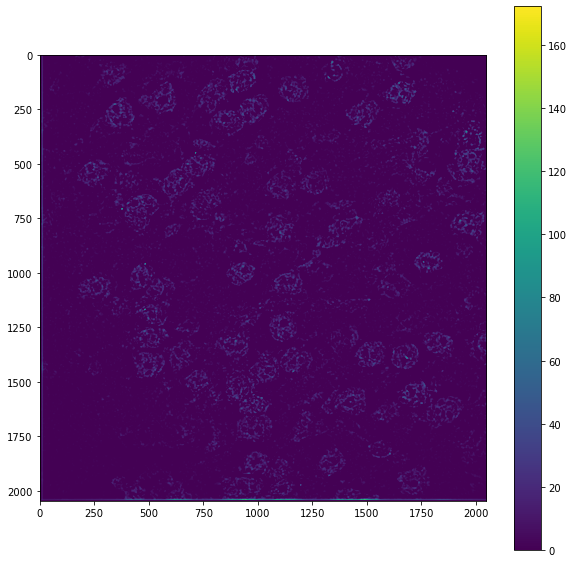

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(cpu(conv).mean(1).mean(0)[0], vmin=0)
maxv = cpu(conv).mean(1).mean(0)[0].max()
plt.colorbar()

In [36]:
fids = get_peaks(cpu(conv).mean(1).mean(0)[0],0.7*maxv,20)
print(len(fids))

18


In [37]:
fids

,x,y,frame_idx,z,loc_idx
0,477,1169,0,0,0
1,943,2041,0,0,1
2,1486,2041,0,0,2
3,373,708,0,0,3
4,479,960,0,0,4
5,709,452,0,0,5
6,973,2041,0,0,6
7,923,2041,0,0,7
8,1085,2041,0,0,8
9,1134,2041,0,0,9


In [47]:
fids[:6].to_csv('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/artifact_coords.csv')

In [38]:
def extract_roi_from_slice_data(vol_5d: torch.Tensor, coordinates: torch.Tensor, size_xy):
    res = []
    
    x, y = coordinates
    crop = np.s_[:,:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = vol_5d[crop]
        
    return single_bead, crop

No handles with labels found to put in legend.


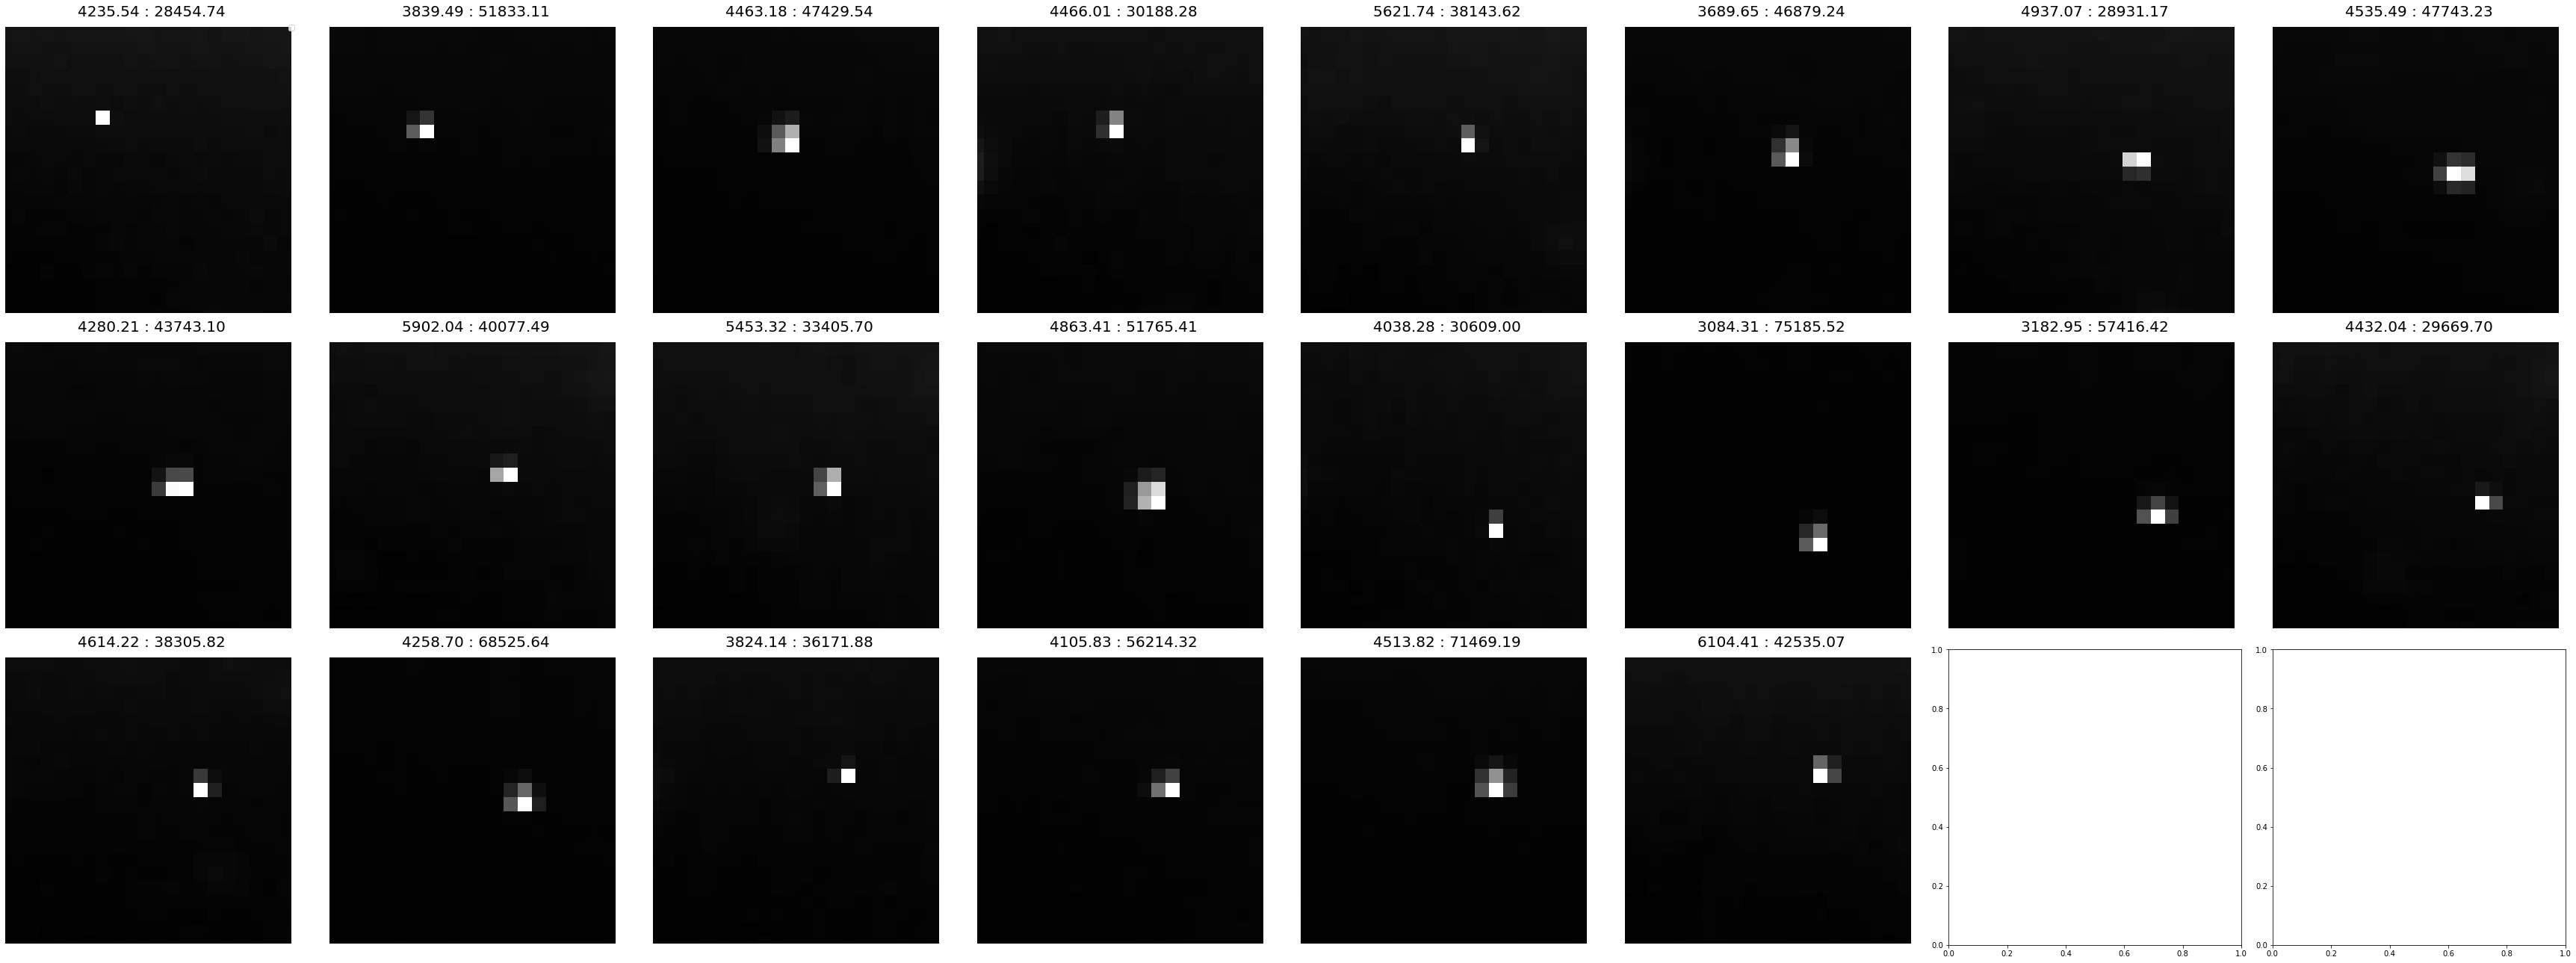

In [44]:
for z in range(1):
    rois, _ = extract_roi_from_slice_data(vol[z:z+1], fids.loc[5,['x','y']], size_xy=10)
    _ = plot_channels(rois[0], n_rows=3)